# Customization

* 整理來源：  
  * 修改自 hands on 那本的 **Chapter 12 – Custom Models and Training with TensorFlow** 。 github 的 notebook 名稱為 **12_custom_models_and_training_with_tensorflow.ipynb**
  * 自訂 metric 整理自
  * 自訂 callback 整理自. 
  * 自訂 fit 整理自

## Setup

### Environment

In [2]:
import sys
assert sys.version_info >= (3, 7) # This project requires Python 3.7 or above

from packaging import version
import tensorflow as tf
# assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import numpy as np

### Data

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

* 拿 california housing 的資料來當範例

In [113]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

* features 有 8 個，y 是 numeric，所以是回歸問題

In [10]:
X_train_scaled.shape

(11610, 8)

In [11]:
y_train

array([[1.442],
       [1.687],
       [1.621],
       ...,
       [0.68 ],
       [0.613],
       [1.97 ]])

## 自訂 loss function

### 不帶參數的 loss function

* 對於回歸問題，最常用的 loss 是 mse
* 但 mse 對 outlier 敏感，所以，我今天想用一個自訂的 loss，叫 `huber loss`  
* 他的定義是：  
  * abs difference of y_true & y_pred < 1 時，用正常的 square error loss / 2
  * abs diff >= 1 時，改成用線性的 loss (i.e. abs diff - 0.5). 
* 那在定義的時候，就是定義一個 function 如下： (特別注意，都要用 tf 的 function 來定義，這樣之後才能順利轉成 graph)

In [112]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

* 看一下這個 loss 的長相：

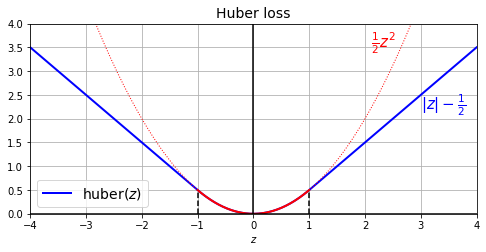

In [7]:
# extra code – shows what the Huber loss looks like

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

* 現在，來 build 一個 model，用這個我們自訂的 loss

In [111]:
input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(
    loss=huber_fn, # 就這樣塞進來就好，就是這麼簡單!
    optimizer="nadam", 
    metrics=["mae"]
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

NameError: name 'huber_fn' is not defined

* 照常做法，把 model 存起來，之後可以用：

In [18]:
model.save("my_model_with_a_custom_loss")

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss/assets


* 讀檔時，必須把 custom_objects 寫入：

In [19]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

* 這樣，就可以繼續 retrain 了：

In [20]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1904 - mean_absolute_error: 0.4699 - val_loss: 0.2363 - val_mean_absolute_error: 0.5045
Epoch 2/2
363/363 [==============================] - 0s 975us/step - loss: 0.1773 - mean_absolute_error: 0.4514 - val_loss: 0.2182 - val_mean_absolute_error: 0.4884


### 帶參數的 loss function

* 那如果我今天的 loss function 帶有參數，例如，剛剛的 huber func，我不希望是定死的 abs diff < 1，而是 abs diff < threshold
* 那這時，就必須用 class 的寫法，且繼承自 `tf.keras.losses.Loss`. 

In [9]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

* 這邊幾個重點講一下：  
  * init 裡面，就放了我要下的參數 `threshold`，以及其他之後想加的參數. 
  * call 裡面，就是原本 loss function 的寫法  
  * get_config 裡面，是把這次有用到的參數寫進去 (e.g. "threshold": self.threshold)，這樣做的用意是，如果你 model 訓練完，存成 .h5 檔時，他會知道你這個模型當初用的 loss 的 threshold 是多少。至於他為啥知道？是因為在 load_model 的時候，他會去 call HuberLoss 裡面的 get_config() 方法 (這個方法繼承自 `tf.keras.losses.Loss`，所以我剛剛自己定義的 HuberLoss 沒明寫這個 method)，然後他從 get_config 就能知道我用的 threshold 是多少了. 
* 那 training 時，就這樣做：

In [10]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 988us/step - loss: 0.4997 - mae: 0.7514 - val_loss: 0.5202 - val_mae: 0.6936
Epoch 2/2
363/363 [==============================] - 0s 788us/step - loss: 0.2781 - mae: 0.5435 - val_loss: 0.3794 - val_mae: 0.5651


* 存檔時，就直接存：

In [12]:
model.save("my_model_with_a_custom_loss_class")  # extra code – saving works

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_class/assets


* 之後，要讀檔，繼續往下 train 時，就是在定義一次 loss class，然後讀檔：

In [13]:
# 也許在別的 python 環境，要 re-train，那就得在定義一次之前用的 loss 的 class

class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# 把 model load 回來的時候，只要在 custom_objects 放入 key-value
# 那他就會去之前存好的 model 的 config 檔中，找到 "HuberLoss" 這個 key，然後叫出之前你存好的參數： threshold，然後用在你寫的 HuberLoss 物件中
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})
# 驗證一下，他有記得 threshold
model.loss.threshold

2.0

* 最後，直接 train 就可以了，不需要再 compile 了：

In [14]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 983us/step - loss: 0.2206 - mean_absolute_error: 0.4783 - val_loss: 0.3241 - val_mean_absolute_error: 0.5093
Epoch 2/2
363/363 [==============================] - 0s 801us/step - loss: 0.2018 - mean_absolute_error: 0.4574 - val_loss: 0.2909 - val_mean_absolute_error: 0.4934


## 自訂 activation, initialze, regularize functions

### 不帶參數版本

* 自己把這些函數寫一寫，只要記得兩個原則：  
  * 用 tf 的 function 來寫 (e.g. 不要用 np.sqrt(), 要用 tf.sqrt())  
  * input 都是 tensor (tf 版的 n-dim array)  

In [4]:
# 自訂 activaton function
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

# 自訂 initializer
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

# 自訂 l1-regularize method
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

# 自訂約束函數，來確保全中都是正的
def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

* 使用時，就是放到 layer 裡面

In [5]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

* training 時就照 train，照 save

In [12]:
input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 1.1668 - mae: 0.7430 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 844us/step - loss: 0.7359 - mae: 0.5977 - val_loss: 2.6252 - val_mae: 0.5870
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model_with_many_custom_parts/assets


* 之後，要 load model時，就像之前一樣，加入 custom_objects 來讀：

In [13]:
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5646 - mean_absolute_error: 0.5293 - val_loss: 0.9063 - val_mean_absolute_error: 0.5070
Epoch 2/2
363/363 [==============================] - 0s 839us/step - loss: 0.4981 - mean_absolute_error: 0.4975 - val_loss: 0.7695 - val_mean_absolute_error: 0.4918


### 帶參數的版本

* 如果這些客製化的函數，是帶有額外參數的，那就要用 class 的寫法，且要繼承適當的 class，例如：  
  * `tf.keras.regularizers.Regularizer`. 
  * `tf.keras.constraints.Constraint`. 
  * `tf.keras.initializers.Initializer`. 
* 底下以 regularizer 來舉例

In [14]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

* fit 的時候 as usual

In [15]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_constraint=my_positive_weights,
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 1.1668 - mae: 0.7430 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 905us/step - loss: 0.7359 - mae: 0.5977 - val_loss: 2.6252 - val_mae: 0.5870
INFO:tensorflow:Assets written to: my_model_with_many_custom_parts/assets


* load 的時候，只要把 class 塞進去就好，他會自己 call `get_config`，取回當初使用的 factor

In [16]:
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5646 - mean_absolute_error: 0.5293 - val_loss: 0.9063 - val_mean_absolute_error: 0.5070
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.4981 - mean_absolute_error: 0.4975 - val_loss: 0.7695 - val_mean_absolute_error: 0.4918


## 自訂 metrics

### from scratch

* 直接講 best practice，就是要去繼承 `tf.keras.metrics.Metric` 這個 class，並且，除了 init 以外，還要定義 3 個 method，以及 get_config:
  * `__init__`: 這個建構子裡面，要放最終去計算 metric 所需的元件。舉例來說，要算 accuracy，那你需要 (正確分類數 / 總數)。那最一開始就會 initialize 這兩個 tf.variable，並 initialize 為 0  
  * `update_state()`，這是每一個 batch 跑完時，要更新目前的 state。舉例來說，如果你最終要算 accuracy，那每個 batch 結束時，就是把正確分類數，加到剛剛的正確分類variable裡面; 把batch總數，加到剛剛的總數 variable 裡、。
  * `result()`： 計算 metric 的邏輯放在這裡。以 accuracy，這邊就會用剛剛訂的 正確分類數 variable，和總數 variable 去做 正確分類/總數 的計算。  
  * `reset_state()`: 整個 epoch 結束後，我們會把所有剛剛計算的東西歸0，因為下一個 epoch 全部重來。
  * `get_config()`: 方便存檔後，load進來，還保有 init 時定義的參數資訊
* 現在，先來寫個自己的 accuracy，並和現有的 accuracy metric 比較，看寫得對不對

#### my_accuracy

In [124]:
class MyAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="my_accuracy", dtype="float32", threshold=0.5, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.threshold = 0.5
        self.true_decision = self.add_weight(
            name = "true_decision", dtype = dtype, initializer = "zeros"
        )
        self.total_number = self.add_weight(
            name = "total_number", dtype = dtype, initializer = "zeros"
        )
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.greater_equal(y_pred, self.threshold) # 此時為 tf.bool 的 type, 例如 [True, False, ..., True]
        y_pred = tf.cast(y_pred, tf.int64) # 轉成 [1, 0, ..., 1]
        
        true_decision = tf.cast(tf.math.equal(y_true, y_pred), self.dtype)
        total_number = tf.cast(tf.size(y_true), self.dtype)

        self.true_decision.assign_add(tf.reduce_sum(true_decision))
        self.total_number.assign_add(total_number)

    def result(self):
        if self.total_number == 0:
            accuracy = tf.cast(0, tf.float32)
        else:
            accuracy = self.true_decision / self.total_number
        return accuracy

    def reset_state(self):
        self.true_decision.assign(0)
        self.total_number.assign(0)
        
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold} 

* 來測試一下：

In [130]:
official_accuracy = tf.keras.metrics.BinaryAccuracy()
my_accuracy = MyAccuracy()

# 起始後，目前的結果
print("----- initialize result -----")
print(official_accuracy.result())
print(my_accuracy.result())

# 第一批資料做完後的結果 (3/5)
official_accuracy.update_state([[1, 0, 1, 1, 0]], [[0.8, 0.3, 0.6, 0.4, 0.6]])
my_accuracy.update_state([[1, 0, 1, 1, 0]], [[0.8, 0.3, 0.6, 0.4, 0.6]])
print("----- end of first batch -----")
print(official_accuracy.result())
print(my_accuracy.result())

# 第二批資料做完後的結果 (2/5 加到原本的 state，變成 (3+2)/(5+5) = 0.5)
official_accuracy.update_state([[1, 1, 1, 0, 0]], [[0.8, 0.3, 0.4, 0.2, 0.6]])
my_accuracy.update_state([[1, 1, 1, 0, 0]], [[0.8, 0.3, 0.4, 0.2, 0.6]])
print("----- end of second batch -----")
print(official_accuracy.result())
print(my_accuracy.result())

----- initialize result -----
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
----- end of first batch -----
tf.Tensor(0.6, shape=(), dtype=float32)
tf.Tensor(0.6, shape=(), dtype=float32)
----- end of second batch -----
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)


* 讚啦！ 那就實際來使用這個 metric 吧：

In [120]:
# data

# x_train 是 tabular data, n = 12, p = 1 (僅 1 個 feature)
x_train = np.array([
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11],
    [12]
])
y_train = np.array([
    [0], 
    [0], 
    [1], 
    [0], 
    [1], 
    [1], 
    [0], 
    [1], 
    [1], 
    [1], 
    [1], 
    [1]
])
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(12).batch(3)

In [126]:
# Instantiate a metric object
my_accuracy = MyAccuracy()

# Prepare our layer, loss, and optimizer.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3, activation="relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid"),
    ]
)
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(2):
    # Iterate over the batches of a dataset.
    for step, (x, y) in enumerate(ds):
        with tf.GradientTape() as tape:
            logits = model(x)
            # Compute the loss value for this batch.
            loss_value = loss_fn(y, logits)

        # Update the state of the `accuracy` metric.
        my_accuracy.update_state(y, logits)

        # Update the weights of the model to minimize the loss value.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Logging the current accuracy value so far.
        print("Epoch:", epoch, "Step:", step)
        print("Total running accuracy so far: %.3f" % my_accuracy.result())
            

    # Reset the metric's state at the end of an epoch
    my_accuracy.reset_state()

Epoch: 0 Step: 0
Total running accuracy so far: 0.333
Epoch: 0 Step: 1
Total running accuracy so far: 0.500
Epoch: 0 Step: 2
Total running accuracy so far: 0.444
Epoch: 0 Step: 3
Total running accuracy so far: 0.333
Epoch: 1 Step: 0
Total running accuracy so far: 0.000
Epoch: 1 Step: 1
Total running accuracy so far: 0.333
Epoch: 1 Step: 2
Total running accuracy so far: 0.222
Epoch: 1 Step: 3
Total running accuracy so far: 0.333


* 或是，更簡單一點，直接用 fit

In [132]:
# Instantiate a metric object
my_accuracy = MyAccuracy()
official_accuracy = tf.keras.metrics.BinaryAccuracy()

# Prepare our layer, loss, and optimizer.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3, activation="relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid"),
    ]
)
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss = loss_fn,
    optimizer = optimizer,
    metrics = [my_accuracy, official_accuracy]
)

model.fit(ds, epochs = 2)

Epoch 1/2
4/4 [==============================] - 0s 1ms/step - loss: 0.5993 - my_accuracy: 0.6667 - binary_accuracy: 0.6667
Epoch 2/2
4/4 [==============================] - 0s 976us/step - loss: 0.5957 - my_accuracy: 0.6667 - binary_accuracy: 0.6667


#### f1_score

* 接著，來實做一下 F1 score (取自: https://keras.io/getting_started/intro_to_keras_for_researchers/#keeping-track-of-training-metrics)

In [151]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", dtype="float32", threshold=0.5, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.threshold = 0.5
        self.true_positives = self.add_weight(
            name="tp", dtype=dtype, initializer="zeros"
        )
        self.false_positives = self.add_weight(
            name="fp", dtype=dtype, initializer="zeros"
        )
        self.false_negatives = self.add_weight(
            name="fn", dtype=dtype, initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.greater_equal(y_pred, self.threshold)
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        true_positives = tf.cast(y_true & y_pred, self.dtype)
        false_positives = tf.cast(~y_true & y_pred, self.dtype)
        false_negatives = tf.cast(y_true & ~y_pred, self.dtype)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            true_positives *= sample_weight
            false_positives *= sample_weight
            false_negatives *= sample_weight

        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.false_positives.assign_add(tf.reduce_sum(false_positives))
        self.false_negatives.assign_add(tf.reduce_sum(false_negatives))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives)
        recall = self.true_positives / (self.true_positives + self.false_negatives)
        return precision * recall * 2.0 / (precision + recall)

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold} 

In [152]:
# Instantiate a metric object
my_accuracy = MyAccuracy()
official_accuracy = tf.keras.metrics.BinaryAccuracy()
official_precision = tf.keras.metrics.Precision(name = "precision")
official_recall = tf.keras.metrics.Recall(name = "recall")

my_f1_score = F1Score()

# Prepare our layer, loss, and optimizer.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3, activation="relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid"),
    ]
)
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss = loss_fn,
    optimizer = optimizer,
    metrics = [my_accuracy, official_accuracy, my_f1_score, official_precision, official_recall]
)

model.fit(ds, epochs = 2)

Epoch 1/2
4/4 [==============================] - 0s 1ms/step - loss: 0.6981 - my_accuracy: 0.2500 - binary_accuracy: 0.2500 - f1_score: nan - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/2
4/4 [==============================] - 0s 1ms/step - loss: 0.6925 - my_accuracy: 0.6667 - binary_accuracy: 0.6667 - f1_score: 0.8000 - precision: 0.6667 - recall: 1.0000


* 存檔時，就照樣存：

In [153]:
model.save("my_model_with_a_custom_metric")

INFO:tensorflow:Assets written to: my_model_with_a_custom_metric/assets


* 讀檔時，跟之前一樣，

In [156]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric",
                                   custom_objects={"MyAccuracy": MyAccuracy, "F1Score": F1Score})

* 可以看到，之前存好的 metric 都在

In [157]:
model.metrics

`model.metrics` contains the model's loss followed by the model's metric(s), so the `HuberMetric` is `model.metrics[-1]`:

* 參數也都記得：

In [162]:
print(model.metrics[1].threshold)
print(model.metrics[3].threshold)

0.5
0.5


* 可以繼續 train

In [163]:
model.fit(ds, epochs = 2)

Epoch 1/2
4/4 [==============================] - 0s 1ms/step - loss: 0.6921 - my_accuracy: 0.6667 - binary_accuracy: 0.6667 - f1_score: 0.8000 - precision: 0.6667 - recall: 1.0000
Epoch 2/2
4/4 [==============================] - 0s 1ms/step - loss: 0.6917 - my_accuracy: 0.6667 - binary_accuracy: 0.6667 - f1_score: 0.8000 - precision: 0.6667 - recall: 1.0000


## 自訂 Layers

* 也參考官網這篇：https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [127]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [128]:
# extra code – like all layers, it can be used as a function:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000).

In [129]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 0s 845us/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 0s 591us/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 0s 585us/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 0s 597us/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 427us/step - loss: 0.3586


0.3586341440677643

Alternatively, it's often preferable to replace the targets with the logarithm of the targets (and use no activation function in the output layer).

In [130]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)  # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [131]:
# extra code – shows that a custom layer can be used normally
tf.random.set_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("my_model_with_a_custom_layer")

Epoch 1/2
363/363 [==============================] - 1s 836us/step - loss: 2.8036 - val_loss: 2.9430
Epoch 2/2
162/162 [==============================] - 0s 426us/step - loss: 0.6557
INFO:tensorflow:Assets written to: my_model_with_a_custom_layer/assets


In [132]:
# extra code – shows how to load a model with a custom layer
model = tf.keras.models.load_model("my_model_with_a_custom_layer",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 892us/step - loss: 0.5665 - val_loss: 0.4506
Epoch 2/2
363/363 [==============================] - 0s 692us/step - loss: 0.4502 - val_loss: 0.5153


In [133]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape1, batch_input_shape1]

Our custom layer can be called using the functional API like this:

In [134]:
# extra code – tests MyMultiLayer with symbolic inputs
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer_4')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer_4')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer_4')>)

Note that the `call()` method receives symbolic inputs, and it returns symbolic outputs. The shapes are only partially specified at this stage: we don't know the batch size, which is why the first dimension is `None`.

We can also pass actual data to the custom layer:

In [135]:
# extra code – tests MyMultiLayer with actual data 
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]]) 
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

Now let's create a layer with a different behavior during training and testing:

In [136]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

Here's a simple model that uses this custom layer:

In [137]:
# extra code – tests MyGaussianNoise
tf.random.set_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 867us/step - loss: 2.1976 - val_loss: 26.5902
Epoch 2/2
162/162 [==============================] - 0s 423us/step - loss: 1.0180


1.0180009603500366

## 自訂 Models

In [138]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [139]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [140]:
# extra code – shows that the model can be used normally
tf.random.set_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model")

Epoch 1/2
363/363 [==============================] - 1s 810us/step - loss: 5.2455
Epoch 2/2
162/162 [==============================] - 0s 512us/step - loss: 0.6072


INFO:tensorflow:Assets written to: my_custom_model/assets


INFO:tensorflow:Assets written to: my_custom_model/assets


In [141]:
# extra code – the model can be loaded and you can continue training or use it
#              to make predictions
model = tf.keras.models.load_model("my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 [==============================] - 1s 879us/step - loss: 0.7176
Epoch 2/2
363/363 [==============================] - 0s 816us/step - loss: 0.5186


array([[0.62953055],
       [1.2767944 ],
       [4.634055  ]], dtype=float32)

We could have defined the model using the sequential API instead:

In [142]:
tf.random.set_seed(42)
block1 = ResidualBlock(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])

## Losses and Metrics Based on Model Internals

**Warning**: due to an issue introduced in TF 2.2 ([#46858](https://github.com/tensorflow/tensorflow/issues/46858)), `super().build()` fails. We can work around this issue by setting `self.built = True` instead.

In [143]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        self.built = True  # WORKAROUND for super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [144]:
# extra code
tf.random.set_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 1s 820us/step - loss: 0.7640 - reconstruction_error: 1.2728
Epoch 2/5
363/363 [==============================] - 0s 809us/step - loss: 0.4584 - reconstruction_error: 0.6340
Epoch 3/5
363/363 [==============================] - 0s 786us/step - loss: 0.4211 - reconstruction_error: 0.4342
Epoch 4/5
363/363 [==============================] - 0s 745us/step - loss: 0.3753 - reconstruction_error: 0.3597
Epoch 5/5
363/363 [==============================] - 0s 772us/step - loss: 0.3618 - reconstruction_error: 0.2908


## 自訂 callback

* 整理自： https://keras.io/guides/writing_your_own_callbacks/

## 自訂 fit

## Computing Gradients Using Autodiff

In [145]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [146]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [147]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [148]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [149]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [150]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
try:
    dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [151]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [152]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [153]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [154]:
gradients

[None, None]

In [155]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [156]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [157]:
# extra code – if given a vector, tape.gradient() will compute the gradient of
#              the vector's sum.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [158]:
# extra code – shows that we get the same result as the previous cell
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [159]:
# extra code – shows how to compute the jacobians and the hessians
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [160]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [161]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [162]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # same result as without stop_gradient()

gradients = tape.gradient(z, [w1, w2])

In [163]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [164]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [165]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [166]:
x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

In [167]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

Here is the proof that this equation is equal to log(1 + exp(_z_)):
* softplus(_z_) = log(1 + exp(_z_))
* softplus(_z_) = log(1 + exp(_z_)) - log(exp(_z_)) + log(exp(_z_)) ; **just adding and subtracting the same value**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + log(exp(_z_)) ; **since log(_a_) - log(_b_) = log(_a_ / _b_)**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + _z_ ; **since log(exp(_z_)) = _z_**
* softplus(_z_) = log\[1 / exp(_z_) + exp(_z_) / exp(_z_)\] + _z_ ; **since (1 + _a_) / _b_ = 1 / _b_ + _a_ / _b_**
* softplus(_z_) = log\[exp(–_z_) + 1\] + _z_ ; **since 1 / exp(_z_) = exp(–z), and exp(_z_) / exp(_z_) = 1**
* softplus(_z_) = softplus(–_z_) + _z_ ; **we recognize the definition at the top, but with –_z_**
* softplus(_z_) = softplus(–|_z_|) + max(0, _z_) ; **if you consider both cases, _z_ < 0 or _z_ ≥ 0, you will see that this works**

In [168]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [169]:
# extra code – shows that the function is now stable, as well as its gradients
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

## 自訂 Training Loops

In [170]:
tf.random.set_seed(42)  # extra code – to ensure reproducibility
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [171]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [172]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [173]:
np.random.seed(42)
tf.random.set_seed(42)

In [174]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [175]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # extra code – if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean: 0.6219 - mean_absolute_error: 0.4975
Epoch 2/5
362/362 - mean: 0.6272 - mean_absolute_error: 0.5049
Epoch 3/5
362/362 - mean: 0.6019 - mean_absolute_error: 0.4951
Epoch 4/5
362/362 - mean: 0.6088 - mean_absolute_error: 0.4971
Epoch 5/5
362/362 - mean: 0.6159 - mean_absolute_error: 0.5032


In [176]:
# extra code – shows how to use the tqdm package to display nice progress bars

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## 自訂 tensorboard 要記錄的東西

## TensorFlow Functions

In [177]:
def cube(x):
    return x ** 3

In [178]:
cube(2)

8

In [179]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [180]:
tf_cube = tf.function(cube)
tf_cube

In [181]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [182]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [183]:
@tf.function
def tf_cube(x):
    return x ** 3

**Note:** the rest of the code in this section is in appendix D.

### TF Functions and Concrete Functions

In [184]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction tf_cube(x) at 0x7F843148D910>

In [185]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [186]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [187]:
concrete_function.graph

In [188]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [189]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [190]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [191]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [192]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [193]:
concrete_function.function_def.signature

name: "__inference_tf_cube_3515915"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [194]:
@tf.function
def tf_cube(x):
    print(f"x = {x}")
    return x ** 3

In [195]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [196]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [197]:
result = tf_cube(2)

x = 2


In [198]:
result = tf_cube(3)

x = 3


In [199]:
result = tf_cube(tf.constant([[1., 2.]]))  # New shape: trace!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [200]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # New shape: trace!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [201]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # Same shape: no trace

It is also possible to specify a particular input signature:

In [202]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)  # extra code to show when tracing happens
    return images[:, ::2, ::2] # drop half the rows and columns

In [203]:
tf.random.set_seed(42)

In [204]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # Works fine, traces the function
preprocessed_images = shrink(img_batch_2)  # Works fine, same concrete function

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [205]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # ValueError! Incompatible inputs
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [206]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [207]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [208]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [209]:
# extra code – shows how to use tf.while_loop (usually @tf.function is simpler)
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [210]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [211]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [212]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [213]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [214]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)  # counter is now equal to 1
increment(counter)  # counter is now equal to 2

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [215]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [216]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [217]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [218]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [219]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [220]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [221]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [222]:
# extra code – shows how to display the autograph code with syntax highlighting
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown(f'```python\n{code}\n```'))

In [223]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [224]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [225]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [226]:
# Custom layer
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [227]:
tf.random.set_seed(42)

In [228]:
# Custom model
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [229]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [230]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
296/363 [=======================>......] - ETA: 0s - loss: 1.5172 - my_mae: 0.8562Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 1s 1ms/step - loss: 1.3255 - my_mae: 0.7900 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 460us/step - loss: 0.4164 - my_mae: 0.4639


[0.4163525104522705, 0.4639028012752533]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [231]:
tf.random.set_seed(42)

In [232]:
model = MyModel(dynamic=True)

In [233]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Now the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [234]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507260322570801, 2.0566811561584473]

Alternatively, you can compile a model with `run_eagerly=True`:

In [235]:
tf.random.set_seed(42)

In [236]:
model = MyModel()

In [237]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [238]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507260322570801, 2.0566811561584473]

## Extra Material – Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [239]:
class MyMomentumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [240]:
tf.random.set_seed(42)

In [241]:
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 444us/step - loss: 4.9648
Epoch 2/5
363/363 [==============================] - 0s 444us/step - loss: 1.7888
Epoch 3/5
363/363 [==============================] - 0s 437us/step - loss: 1.0021
Epoch 4/5
363/363 [==============================] - 0s 451us/step - loss: 0.7869
Epoch 5/5
363/363 [==============================] - 0s 446us/step - loss: 0.7122
